# Statistics for wine volume regression model

Mean absolute error for laboratory images of glasses and cups model.

In [1]:
import os
import json

import numpy as np
import matplotlib.pylab as plt
from tensorflow.keras.models import load_model

from imgclas import paths, utils, data_utils
from imgclas.data_utils import load_data_splits, k_crop_data_sequence
from imgclas.test_utils import predict
from imgclas.visualization.saliency import GradientSaliency
from imgclas.visualization.guided_backprop import GuidedBackprop
from imgclas.visualization.integrated_gradients import IntegratedGradients
from imgclas.visualization.visual_backprop import VisualBackprop

# User parameters to set
TIMESTAMP = '2021-11-03_Lab_All_CopasVasos_All_reg'                       # timestamp of the model
MODEL_NAME = 'final_model.h5'                           # model to use to make the prediction
TOP_K = 2                                               # number of top classes predictions to save

# Set the timestamp
paths.timestamp = TIMESTAMP

# Load training configuration
conf_path = os.path.join(paths.get_conf_dir(), 'conf.json')
with open(conf_path) as f:
    conf = json.load(f)
    
# Load the model
model = load_model(os.path.join(paths.get_checkpoints_dir(), MODEL_NAME), custom_objects=utils.get_custom_objects(), compile=True)

W1119 09:35:18.208162 139812046260032 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:97: calling GlorotUniform.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W1119 09:35:18.210899 139812046260032 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W1119 09:35:18.212519 139812046260032 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:97: calling Zeros.__init__ (from tensorflow.python.ops.init_ops) with dtyp

In [217]:
import pandas as pd
# Load back the predictions
SPLIT_NAME='test'
pred_path = os.path.join(paths.get_predictions_dir(), '{}+{}.json'.format(MODEL_NAME, SPLIT_NAME, TOP_K))
with open(pred_path) as f:
    pred_dict = json.load(f)

df_pred=pd.DataFrame(pred_dict)
df_pred['abs_error']=abs(df_pred.pred_value-df_pred.true_value)

In [218]:
# extract values of angle, plane and background in all images
df_pred['plane'] = df_pred.apply(lambda row: row.filenames.split('_')[-2], axis=1)
df_pred['angle'] = df_pred.apply(lambda row: row.filenames.split('_')[-1].split('.')[0], axis=1)
df_pred['back'] = df_pred.apply(lambda row: row.filenames.split('_')[-4], axis=1)
df_pred['vol'] = df_pred.apply(lambda row: row.filenames.split('_')[4], axis=1)
df_pred['glass'] = df_pred.apply(lambda row: row.filenames.split('_')[3], axis=1)
df_pred['ref'] = df_pred.apply(lambda row: row.filenames.split('_')[-3], axis=1)
df_pred['light'] = df_pred.apply(lambda row: row.filenames.split('_')[-5], axis=1)
df_pred.head(5)

,filenames,pred_value,true_value,abs_error,plane,angle,back,vol,glass,ref,light
0,/srv/datos/Laboratorio/La Rioja/ICVV/Copa Char...,74.349709,75,0.650291,ce,cen,az,75,Char,con,nf
1,/srv/datos/Laboratorio/La Rioja/ICVV/Vaso Dura...,95.382797,100,4.617203,me,sup1,bl,100,Dura,sin,nf
2,/srv/datos/Laboratorio/Madrid/copa Char/Fondo ...,194.206573,200,5.793427,ce,inf,bl,200,Char,con,f
3,/srv/datos/Laboratorio/Madrid/copa Char/Fondo ...,195.143982,200,4.856018,me,inf,bl,200,Char,sin,nf
4,/srv/datos/Laboratorio/La Rioja/ICVV/Copa Borg...,98.471153,100,1.528847,me,sup1,bl,100,Bor,con,f


In [219]:
df_pred['vol']=df_pred.vol.astype(int)
df_pred['rel_error']=df_pred.abs_error/df_pred.vol

In [295]:
# groups
df_vols=df_pred.groupby(['vol'], as_index=False)['abs_error'].mean()
df_backs=df_pred.groupby(['back'], as_index=False)['abs_error'].mean()
df_planes=df_pred.groupby(['plane'], as_index=False)['abs_error'].mean()
df_angles=df_pred.groupby(['angle'], as_index=False)['abs_error'].mean()
df_glasses=df_pred.groupby(['glass'], as_index=False)['abs_error'].mean()
df_ref=df_pred.groupby(['ref'], as_index=False)['abs_error'].mean()
df_light=df_pred.groupby(['light'], as_index=False)['abs_error'].mean()

In [296]:
custom_dict = {'inf': 0, 'cen': 1, 'sup1': 2, 'sup': 3}
df_angles=df_angles.sort_values(by=['angle'], key=lambda x: x.map(custom_dict))

custom_dict = {'ce': 0, 'me': 1, 'al': 2}
df_planes=df_planes.sort_values(by=['plane'], key=lambda x: x.map(custom_dict))

custom_dict = {'f': 0, 'nf': 1, 'ext': 2, 'nd': 3}
df_light=df_light.sort_values(by=['light'], key=lambda x: x.map(custom_dict))

custom_dict = {'con': 0, 'sin': 1, 'nd': 2}
df_ref=df_ref.sort_values(by=['ref'], key=lambda x: x.map(custom_dict))

In [299]:
# rename values 
df_glasses['glass'].loc[(df_glasses['glass'] == 'Chiqu')] = 'Chiqui'

df_backs['back'].loc[(df_backs['back'] == 'nd')] = 'outside'
df_backs['back'].loc[(df_backs['back'] == 'bl')] = 'white'
df_backs['back'].loc[(df_backs['back'] == 'az')] = 'blue'

df_ref['ref'].loc[(df_ref['ref'] == 'nd')] = 'unknown'
df_ref['ref'].loc[(df_ref['ref'] == 'con')] = 'yes'
df_ref['ref'].loc[(df_ref['ref'] == 'sin')] = 'no'

df_planes['plane'].loc[(df_planes['plane'] == 'al')] = '[50, 70]'
df_planes['plane'].loc[(df_planes['plane'] == 'me')] = '[20, 30]'
df_planes['plane'].loc[(df_planes['plane'] == 'ce')] = '[10, 15]'

df_angles['angle'].loc[(df_angles['angle'] == 'sup')] = '(0, 60]'
df_angles['angle'].loc[(df_angles['angle'] == 'sup1')] = '(0, 30]'
df_angles['angle'].loc[(df_angles['angle'] == 'cen')] = '0'
df_angles['angle'].loc[(df_angles['angle'] == 'inf')] = '[-30, 0)'

df_light['light'].loc[(df_light['light'] == 'f')] = 'inside (flash)'
df_light['light'].loc[(df_light['light'] == 'nf')] = 'inside (no flash)'
df_light['light'].loc[(df_light['light'] == 'ext')] = 'outside'
df_light['light'].loc[(df_light['light'] == 'nd')] = 'unknown'

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


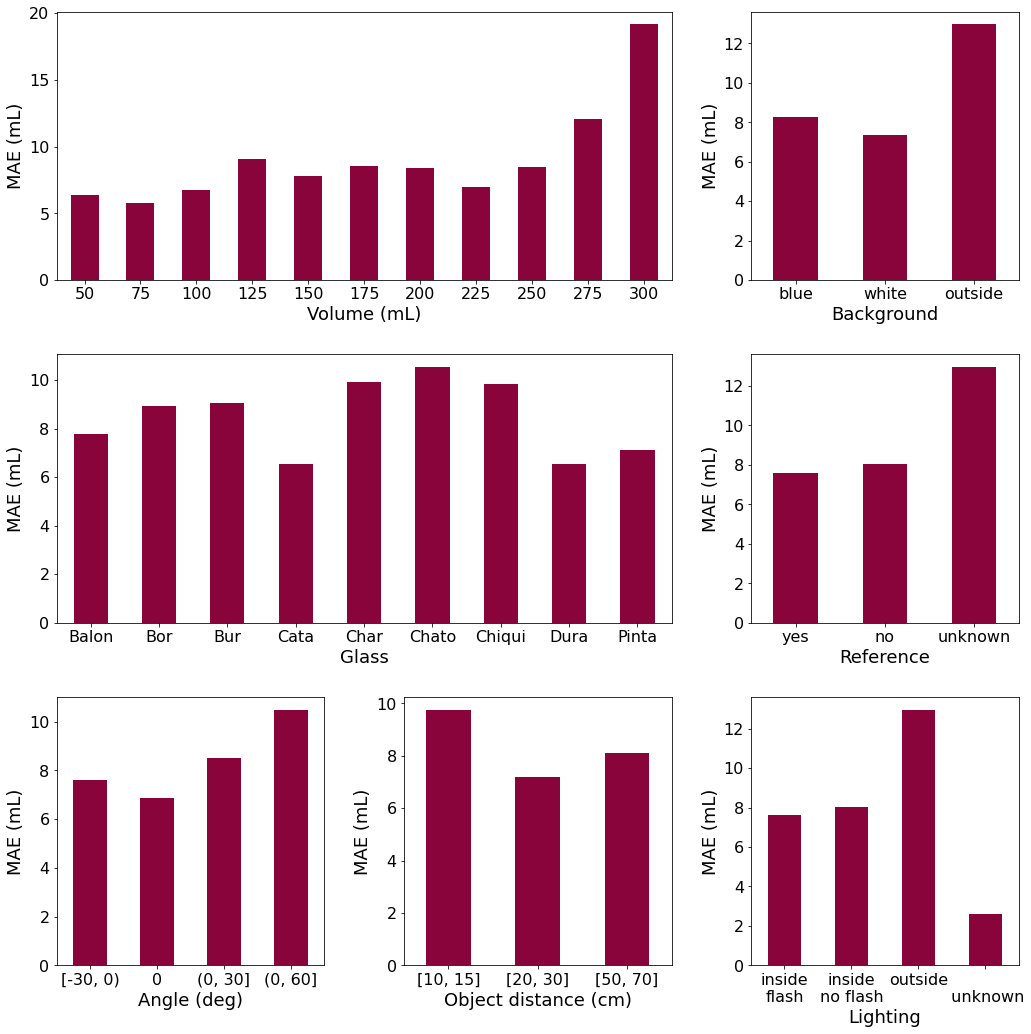

In [300]:
figsize = 5

fig, axs = plt.subplots(3, 3, figsize=(figsize*3, figsize*3))

gs = axs[0, 0].get_gridspec()
# remove the underlying axes
for ax in axs[0, 0:-1]:
    ax.remove()
axbig = fig.add_subplot(gs[0, 0:-1])

df_vols.plot.bar(x='vol', y='abs_error', ax=axbig, color=['#8a043c'], legend=None)
axbig.set_xlabel('Volume (mL)', fontsize=18)
axbig.set_ylabel('MAE (mL)', fontsize=18)
axbig.tick_params(axis='x', rotation=0)
axbig.tick_params(axis='both', which='major', labelsize=16)

df_backs.plot.bar(x='back', y='abs_error', ax=axs[0,2], color=['#8a043c'], legend=None)
axs[0,2].set_xlabel('Background', fontsize=18)
axs[0,2].set_ylabel('MAE (mL)', fontsize=18)
axs[0,2].tick_params(axis='x', rotation=0)
axs[0,2].tick_params(axis='both', which='major', labelsize=16)

gs = axs[1, 0].get_gridspec()
# remove the underlying axes
for ax in axs[1, 0:-1]:
    ax.remove()
axbig2 = fig.add_subplot(gs[1, 0:-1])

df_glasses.plot.bar(x='glass', y='abs_error', ax=axbig2, color=['#8a043c'], legend=None)
axbig2.set_xlabel('Glass', fontsize=18)
axbig2.set_ylabel('MAE (mL)', fontsize=18)
axbig2.tick_params(axis='x', rotation=0)
axbig2.tick_params(axis='both', which='major', labelsize=16)

df_ref.plot.bar(x='ref', y='abs_error', ax=axs[1,2], color=['#8a043c'], legend=None)
axs[1,2].set_xlabel('Reference', fontsize=18)
axs[1,2].set_ylabel('MAE (mL)', fontsize=18)
axs[1,2].tick_params(axis='x', rotation=0)
axs[1,2].tick_params(axis='both', which='major', labelsize=16)

df_angles.plot.bar(x='angle', y='abs_error', ax=axs[2,0], color=['#8a043c'], legend=None)
axs[2,0].set_xlabel('Angle (deg)', fontsize=18)
axs[2,0].set_ylabel('MAE (mL)', fontsize=18)
axs[2,0].tick_params(axis='x', rotation=0)
axs[2,0].tick_params(axis='both', which='major', labelsize=16)

df_planes.plot.bar(x='plane', y='abs_error', ax=axs[2,1], color=['#8a043c'], legend=None)
axs[2,1].set_xlabel('Object distance (cm)', fontsize=18)
axs[2,1].set_ylabel('MAE (mL)', fontsize=18)
axs[2,1].tick_params(axis='x', rotation=0)
axs[2,1].tick_params(axis='both', which='major', labelsize=16)

df_light.plot.bar(x='light', y='abs_error', ax=axs[2,2], color=['#8a043c'], legend=None)
axs[2,2].set_xlabel('Lighting', fontsize=18)
axs[2,2].set_ylabel('MAE (mL)', fontsize=18)
labels = [item.get_text() for item in axs[2,2].get_xticklabels()]
labels[0] = 'inside\nflash'
labels[1] = 'inside\nno flash'
labels[2] = 'outside'
labels[3] = '\n unknown'
axs[2,2].set_xticklabels(labels)
axs[2,2].tick_params(axis='x', rotation=0)
axs[2,2].tick_params(axis='both', which='major', labelsize=16)

# for ax in axs:
#    ax.tick_params(axis='both', which='major', labelsize=16)
    
fig.tight_layout(pad=3.0)
plt.savefig('/srv/image-results/abs_error.pdf',bbox_inches='tight')